# Müşteri Davranış Analizi ve Satış Tahmini

Bu not defteri; **veri yükleme**, **büyük sentetik veri üretimi**, **EDA**, ve **SARIMA / Prophet / XGBoost** ile tahmin ve kıyaslamayı içerir.

In [27]:
import sys, subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install", "prophet", "xgboost"])
import numpy as np
from sklearn.metrics import mean_absolute_error

try:
    from sklearn.metrics import root_mean_squared_error
    def RMSE(y_true, y_pred):
        return root_mean_squared_error(y_true, y_pred)
except Exception:
    from sklearn.metrics import mean_squared_error
    def RMSE(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

## 1) Kurulum ve Kütüphaneler

In [5]:
import os, sqlite3, random
from datetime import datetime
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
try:
    from sklearn.metrics import root_mean_squared_error
    def RMSE(y_true, y_pred):
        return root_mean_squared_error(y_true, y_pred)
except ImportError:
    from sklearn.metrics import mean_squared_error
    def RMSE(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 140)

## 2) Proje Konfigürasyonu ve SQLite (Sağlam Şema Yükleme)

In [8]:
from pathlib import Path

BASE_DIR = Path(os.getcwd()).resolve()
DATA_DIR = BASE_DIR / "data"
DATA_DIR.mkdir(exist_ok=True)

DB_PATH = BASE_DIR / "sales.db"
conn = sqlite3.connect(str(DB_PATH))
cur = conn.cursor()

# SQL dosyası arama ve fallback
sql_candidates = [
    BASE_DIR / "create_tables.sql",
    Path("/mnt/data/sales_forecast_project") / "create_tables.sql",
]

schema_sql = """CREATE TABLE IF NOT EXISTS customers (
    customer_id INTEGER PRIMARY KEY,
    segment TEXT,
    city TEXT,
    created_at TEXT
);
CREATE TABLE IF NOT EXISTS products (
    product_id INTEGER PRIMARY KEY,
    category TEXT,
    price REAL
);
CREATE TABLE IF NOT EXISTS orders (
    order_id INTEGER PRIMARY KEY,
    customer_id INTEGER,
    order_date TEXT,
    total_amount REAL
);
CREATE TABLE IF NOT EXISTS order_items (
    order_item_id INTEGER PRIMARY KEY,
    order_id INTEGER,
    product_id INTEGER,
    quantity INTEGER,
    line_total REAL
);"""

sql_used = None
for cand in sql_candidates:
    if cand.exists():
        with open(cand, "r", encoding="utf-8") as f:
            cur.executescript(f.read())
        sql_used = str(cand)
        break

if sql_used is None:
    cur.executescript(schema_sql)
    sql_used = "[fallback embedded schema]"

conn.commit()
print("DB hazır:", DB_PATH)
print("Şema kaynağı:", sql_used)

DB hazır: C:\Users\burak\OneDrive\Masaüstü\sales.db
Şema kaynağı: [fallback embedded schema]


## 3) Büyük Sentetik Veri Üretimi (2019–2024, 1000 müşteri, 200 ürün)

In [11]:
np.random.seed(13); random.seed(13)

N_CUSTOMERS = 1000
N_PRODUCTS = 200

customers = pd.DataFrame({
    "customer_id": range(1, N_CUSTOMERS+1),
    "segment": np.random.choice(["Retail","SME","Enterprise"], size=N_CUSTOMERS, p=[0.6,0.3,0.1]),
    "city": np.random.choice(["İstanbul","Ankara","İzmir","Bursa","Antalya","Adana","Konya"], size=N_CUSTOMERS),
    "created_at": pd.date_range("2019-01-01", periods=N_CUSTOMERS, freq="D").astype(str)
})

products = pd.DataFrame({
    "product_id": range(1, N_PRODUCTS+1),
    "category": np.random.choice(["Elektronik","Giyim","Ev","Spor","Kozmetik","Oyuncak"], size=N_PRODUCTS),
    "price": np.round(np.random.uniform(50, 5000, size=N_PRODUCTS), 2)
})

dates = pd.date_range("2019-01-01", "2024-12-31", freq="D")

orders_list, order_items_list = [], []
order_id, order_item_id = 1, 1

for d in dates:
    day_of_year = d.timetuple().tm_yday
    seasonal = 25 + 10*np.sin(2*np.pi*day_of_year/365.0)
    weekday_boost = 8 if d.weekday() < 5 else -5
    year_trend = (d.year - 2019) * 2.5
    promo = 12 if d.month in [11,12] else 0
    lam = max(5, seasonal + weekday_boost + year_trend + promo)
    day_orders = np.random.poisson(lam=lam)

    for _ in range(day_orders):
        cid = int(np.random.choice(customers.customer_id))
        total = 0.0
        n_items = np.random.randint(1, 5)
        for __ in range(n_items):
            pid = int(np.random.choice(products.product_id))
            qty = int(np.random.randint(1, 6))
            price = float(products.loc[products.product_id == pid, "price"].iloc[0])
            line_total = qty * price
            total += line_total
            order_items_list.append((order_item_id, order_id, pid, qty, round(line_total, 2)))
            order_item_id += 1
        orders_list.append((order_id, cid, d.strftime("%Y-%m-%d"), round(total, 2)))
        order_id += 1

orders = pd.DataFrame(orders_list, columns=["order_id","customer_id","order_date","total_amount"])
order_items = pd.DataFrame(order_items_list, columns=["order_item_id","order_id","product_id","quantity","line_total"])

customers.to_sql("customers", conn, if_exists="replace", index=False)
products.to_sql("products", conn, if_exists="replace", index=False)
orders.to_sql("orders", conn, if_exists="replace", index=False)
order_items.to_sql("order_items", conn, if_exists="replace", index=False)
conn.commit()

print("Büyük sentetik veri yazıldı: orders:", orders.shape, "order_items:", order_items.shape)

Büyük sentetik veri yazıldı: orders: (82315, 4) order_items: (206079, 5)


## 4) Günlük Seri ve EDA

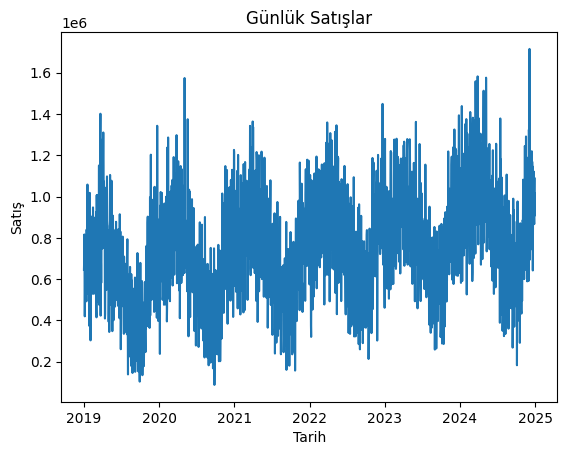

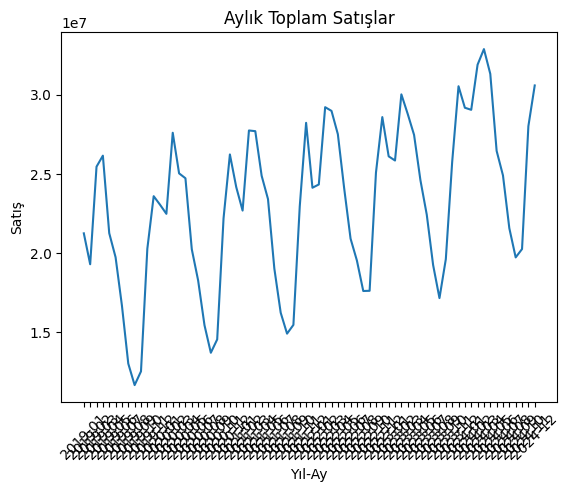

In [14]:
df_orders = pd.read_sql_query("SELECT order_id, order_date, total_amount FROM orders", conn, parse_dates=["order_date"])
df_orders["order_date"] = pd.to_datetime(df_orders["order_date"])
daily_sales = df_orders.groupby("order_date", as_index=False)["total_amount"].sum().rename(columns={"total_amount":"sales"})


full_dates = pd.DataFrame({"order_date": pd.date_range(daily_sales.order_date.min(), daily_sales.order_date.max(), freq="D")})
daily_sales = full_dates.merge(daily_sales, on="order_date", how="left").fillna({"sales":0.0})

plt.figure()
plt.plot(daily_sales["order_date"], daily_sales["sales"])
plt.title("Günlük Satışlar"); plt.xlabel("Tarih"); plt.ylabel("Satış"); plt.show()

monthly = daily_sales.copy()
monthly["year_month"] = monthly["order_date"].dt.to_period("M").astype(str)
monthly = monthly.groupby("year_month", as_index=False)["sales"].sum()

plt.figure()
plt.plot(monthly["year_month"], monthly["sales"])
plt.title("Aylık Toplam Satışlar"); plt.xlabel("Yıl-Ay"); plt.ylabel("Satış"); plt.xticks(rotation=45); plt.show()

## 5) SARIMA Modeli

SARIMA - MAE: 406964.63 | RMSE: 481808.38


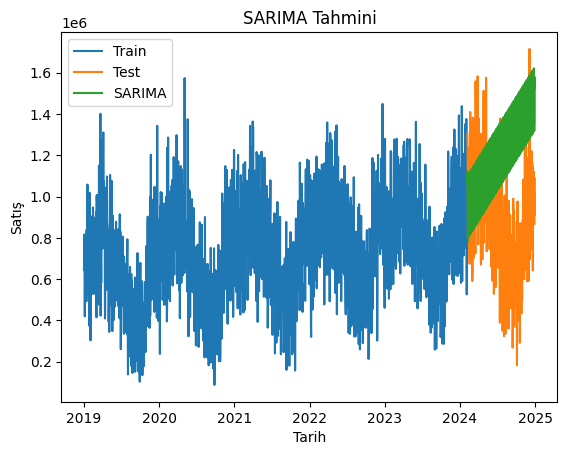

In [17]:
ts = daily_sales.set_index("order_date")["sales"].asfreq("D").fillna(0.0)
train_end = int(len(ts) * 0.85)
ts_train, ts_test = ts.iloc[:train_end], ts.iloc[train_end:]

model = SARIMAX(ts_train, order=(1,1,1), seasonal_order=(1,1,1,7), enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False)

forecast = res.get_forecast(steps=len(ts_test))
pred_mean = forecast.predicted_mean

mae = mean_absolute_error(ts_test.values, pred_mean.values)
rmse = RMSE(ts_test.values, pred_mean.values)
print("SARIMA - MAE:", round(mae,2), "| RMSE:", round(rmse,2))

plt.figure()
plt.plot(ts_train.index, ts_train.values, label="Train")
plt.plot(ts_test.index, ts_test.values, label="Test")
plt.plot(pred_mean.index, pred_mean.values, label="SARIMA")
plt.title("SARIMA Tahmini"); plt.xlabel("Tarih"); plt.ylabel("Satış"); plt.legend(); plt.show()

## 6) Naive Baseline (7-gün ortalaması)

In [20]:
naive = pd.Series(ts_train.tail(7).mean(), index=ts_test.index)
mae_naive = mean_absolute_error(ts_test.values, naive.values)
rmse_naive = RMSE(ts_test.values, naive.values)
print("Naive - MAE:", round(mae_naive,2), "| RMSE:", round(rmse_naive,2))

Naive - MAE: 213399.53 | RMSE: 267307.06


## 7) Prophet ile Tahmin

23:32:13 - cmdstanpy - INFO - Chain [1] start processing
23:32:13 - cmdstanpy - INFO - Chain [1] done processing


Prophet - MAE: 128098.53 | RMSE: 162484.03


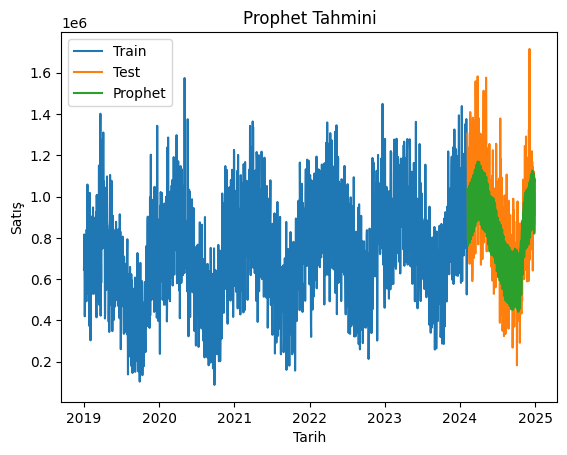

In [29]:
from prophet import Prophet

df_prophet = daily_sales.rename(columns={"order_date":"ds", "sales":"y"})
m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
m.fit(df_prophet)

future = m.make_future_dataframe(periods=len(ts_test), freq="D")
forecast_p = m.predict(future)
pred_p = forecast_p.set_index("ds").loc[ts_test.index, "yhat"]

mae_p = mean_absolute_error(ts_test.values, pred_p.values)
rmse_p = RMSE(ts_test.values, pred_p.values)
print("Prophet - MAE:", round(mae_p,2), "| RMSE:", round(rmse_p,2))

plt.figure()
plt.plot(ts_train.index, ts_train.values, label="Train")
plt.plot(ts_test.index, ts_test.values, label="Test")
plt.plot(pred_p.index, pred_p.values, label="Prophet")
plt.title("Prophet Tahmini"); plt.xlabel("Tarih"); plt.ylabel("Satış"); plt.legend(); plt.show()

## 8) XGBoost ile Özellik Tabanlı Tahmin

XGBoost - MAE: 128652.88 | RMSE: 162111.36


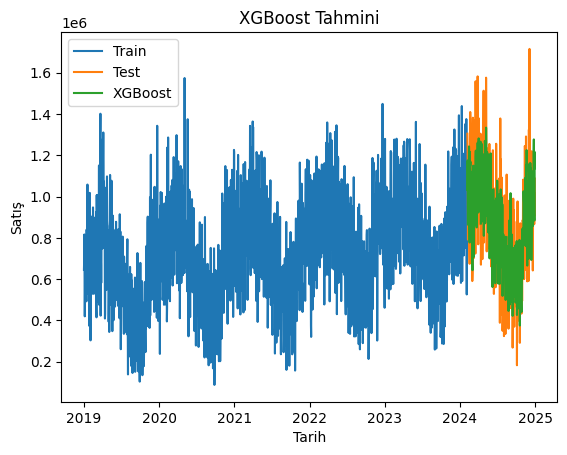

In [31]:
from xgboost import XGBRegressor

def make_features(s, lags=(1,7,14,28), rolls=(7,14,28)):
    df = s.to_frame("sales").copy()
    df["dow"] = df.index.dayofweek
    df["month"] = df.index.month
    df["day"] = df.index.day
    for L in lags:
        df[f"lag_{L}"] = df["sales"].shift(L)
    for R in rolls:
        df[f"roll_mean_{R}"] = df["sales"].rolling(R).mean()
    return df

feat = make_features(ts).dropna()
split_idx = ts.index[train_end]
X = feat.drop(columns=["sales"]).astype(float)
y = feat["sales"].astype(float)

X_train = X.loc[:split_idx].iloc[:-1]
y_train = y.loc[X_train.index]
X_test  = X.loc[ts_test.index]
y_test  = y.loc[ts_test.index]

model_xgb = XGBRegressor(
    n_estimators=700, max_depth=6, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8,
    objective="reg:squarederror", random_state=42
)
model_xgb.fit(X_train, y_train)

pred_x = model_xgb.predict(X_test)
mae_x = mean_absolute_error(y_test.values, pred_x)
rmse_x = RMSE(y_test.values, pred_x)
print("XGBoost - MAE:", round(mae_x,2), "| RMSE:", round(rmse_x,2))

plt.figure()
plt.plot(ts_train.index, ts_train.values, label="Train")
plt.plot(ts_test.index, ts_test.values, label="Test")
plt.plot(ts_test.index, pred_x, label="XGBoost")
plt.title("XGBoost Tahmini"); plt.xlabel("Tarih"); plt.ylabel("Satış"); plt.legend(); plt.show()

## 9) Modellerin Karşılaştırması

In [33]:
results = pd.DataFrame([
    {"Model":"Naive(7g ort.)", "MAE": round(mae_naive,2), "RMSE": round(rmse_naive,2)},
    {"Model":"SARIMA(1,1,1)(1,1,1,7)", "MAE": round(mae,2), "RMSE": round(rmse,2)},
    {"Model":"Prophet", "MAE": round(mae_p,2), "RMSE": round(rmse_p,2)},
    {"Model":"XGBoost", "MAE": round(mae_x,2), "RMSE": round(rmse_x,2)},
])
results

,Model,MAE,RMSE
0,Naive(7g ort.),213399.53,267307.06
1,"SARIMA(1,1,1)(1,1,1,7)",406964.63,481808.38
2,Prophet,128098.53,162484.03
3,XGBoost,128652.88,162111.36
